In [1]:
# Import dependencies
import unittest
import random
import math 
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable 
import torch.nn
import torch.distributions.constraints as constraints
import pyro 
import pyro.infer
import pyro.optim
import pyro.distributions as dist

Data size = 10000
..........

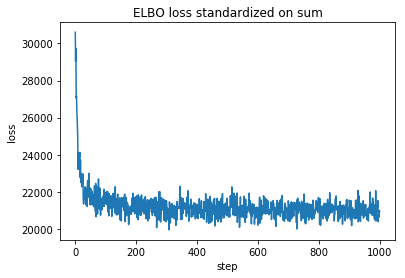


 MSE distance between true posterior and variational approximation = 7.85412557888776e-05 



 Latent posterior pdf = [   0.82468963  117.01078796    0.84210151  263.21603394    0.58652073
   14.03238869    0.83595538    2.55041647   32.23901749   36.11444092
    0.81741542   15.40153313    5.7608757    25.35027313    0.88225901
  105.98616791    0.59654731   53.2504425   209.52096558  120.82151794] 



 Inferred entropy = -89.56372790725436 



 Inferred variance = [  8.12371468e-07   1.01948499e-04   8.29508906e-07   1.91643834e-04
   5.77896799e-07   1.36412791e-05   8.23459743e-07   2.50801122e-06
   3.07656010e-05   3.43268330e-05   8.05211698e-07   1.49516109e-05
   5.64697712e-06   2.43627219e-05   8.69031226e-07   9.34873824e-05
   5.87770103e-07   4.97209621e-05   1.63567340e-04   1.04817773e-04] 




In [2]:
# Init seed and enable validation
pyro.enable_validation(True)
torch.manual_seed(123)
np.random.seed(123)
random.seed(123)

# Init data size 
N = 10000
print("Data size = {}".format(N))


def create_data(N):
    """ Simulate N die rolls """
    
    # Randomly initialize condition of a 20 sided die
    die_probs = pyro.sample("die_probs", dist.Dirichlet(torch.rand(20)))
    
    # Roll die N times
    data = pyro.sample("data", dist.Categorical(die_probs).expand_by([N]))
    return die_probs, data


def close_enough(parameter, target):
    """ Compute MSE distance of parameter estimate 
        from target
    """
    # Create normalized versions of input probabilities
    param_norm = pyro.param(parameter)/torch.sum(pyro.param(parameter))
    target_norm = target/torch.sum(target)
    return torch.sum(torch.pow(param_norm - target_norm, 2)).item()


class DirichletCategoricalDie(object):
    def __init__(self, N):
        
        # Register dataset and true probs
        die_probs, data = create_data(N)
        self.data = data
        self.die_probs = die_probs
        self.len = N
        
        # Init Dirichlet hyperparameters
        self.alphas = 2*torch.ones(20)
    
        # Init variational parameters
        self.alphas_q = 5*torch.ones(20)

        # Create hashtable and add pseudocounts
        alphas_data = list(self.alphas.data.numpy())  
        posterior_dict = {idx:int(i) for idx, i in enumerate(alphas_data)}
            
        # Add counts from data
        for param in self.data:
            posterior_dict[int(param.data.numpy())] += 1
        alphas_true = torch.Tensor(list(posterior_dict.values()))
        
        # Store exact posterior parameters
        self.alphas_true = alphas_true
        
        
    def model(self):
        """ Define hypothesized data generating process """
        
        # Sample from Dirichlet prior
        model_prior = pyro.sample("latent_probs", dist.Dirichlet(self.alphas))
        
        # Condition model on observations using data
        with pyro.iarange("model_iarange", size=len(self.data), 
                          subsample_size = 500) as ind:
            pyro.sample("obs", dist.Categorical(model_prior),
                        obs = self.data.index_select(0, ind))
        
    def guide(self):
        """ Define variational distribution to 
            infer latent variables 
        """
        
        # Register variational parameters
        alphas_q = pyro.param("alphas_q", self.alphas_q,
                              constraint = constraints.positive)
        
        # Assert same model-guide signature by
        # sampling latent variable and 
        # using a decaying average baseline 
        return pyro.sample("latent_probs", dist.Dirichlet(alphas_q), 
                            infer = {'use_decaying_avg_baseline': True,
                            'baseline_beta': 0.90})
        
    def infer(self):
        """ Use SVI to infer latent variables.
            Print difference between true 
            posterior parameters and optimized parameters
            as well as variance and entropy of posterior
        """
        # Init any pre-existing params
        pyro.clear_param_store()
        
        # Optimize using SGD and use a TraceGraph_ELBO loss 
        # to reduce variance using Rao-Blackwellization 
        optimizer = pyro.optim.SGD({"lr": 0.0001})
        svi = pyro.infer.SVI(self.model, self.guide, optimizer, 
                             loss=pyro.infer.TraceGraph_ELBO())

        # Perform (only!) 1k steps of inference 
        losses = []
        for k in range(1000):
            if k % 100 == 0:
                print('.', end='')
            if k == 0:
                losses.append(svi.step())
            else:
                # Test whether variational parameters 
                # update at each step
                temp_alphas_old = pyro.param("alphas_q").data
                losses.append(svi.step())
                temp_alphas_new = pyro.param("alphas_q").data  
                assert not (torch.equal(temp_alphas_old, temp_alphas_new))
                
        # Plot Loss
        # Note: loss standardized on sum, not mean
        plt.plot(losses)
        plt.title("ELBO loss standardized on sum")
        plt.xlabel("step")
        plt.ylabel("loss")
        plt.show()

        # Print L2 errors of optimized estimate
        # as well as entropy and variance
        alphas_error = close_enough("alphas_q", self.alphas_true)
        alphas_q = pyro.param("alphas_q").data.numpy()
        entropy = scipy.stats.dirichlet.entropy(alphas_q)
        variance = scipy.stats.dirichlet.var(alphas_q)
        
        # Test whether predictions are close to true values
        assert(alphas_error < 0.1)
        print(("\n MSE distance between true posterior" +
               " and variational approximation = {} \n\n").format((alphas_error)))
        print("\n Latent posterior pdf = {} \n\n".format(alphas_q))
        
        # We thus expect a low entropy since the die is almost fair
        print("\n Inferred entropy = {} \n\n".format(entropy))
        print("\n Inferred variance = {} \n\n".format(variance))
        
        

dcd = DirichletCategoricalDie(N)
dcd.infer()